%% [markdown]<br>
# Broadcast Add<br>
:label:`ch_bcast_add_cpu`<br>
<br>
This section talks about scheduling the broadcast add computation defined in :numref:`ch_bcast_add` on CPU. The optimization of it is similar to what we have done for vector add in :numref:`ch_vector_add_cpu`, as they are both essentially memory-bound element-wise calculation. Hence, instead of "what works", we will talk about "what doesn't work" in this section.<br>
<br>
## Setup<br>


%%<br>
matplotlib inline

In [1]:
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te
import platform # 导入 platform 模块用于获取系统信息
import logging  # 导入 logging 模块用于添加日志

配置日志

In [2]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [3]:
logging.info(f"系统信息: {platform.platform()}")
logging.info(f"CPU 架构: {platform.machine()}")
logging.info(f"处理器型号: {platform.processor()}")
logging.info(f"NumPy 版本: {np.__version__}")
logging.info(f"TVM 版本: {tvm.__version__}")

INFO: 系统信息: Linux-6.5.0-18-generic-x86_64-with-glibc2.35
INFO: CPU 架构: x86_64
INFO: 处理器型号: x86_64
INFO: NumPy 版本: 1.23.5
INFO: TVM 版本: 0.19.0


%%

In [4]:
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    d2ltvm.plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

%% [markdown]<br>
Here we choose the broadcast add depicted in :numref:`fig_bcast_add`. The other broadcast patterns do not make essential difference.<br>
<br>
First, we define the baseline in `numpy`. We use the real used data sizes in the x axis.<br>


%%

In [5]:
sizes = 2**np.arange(5, 15, 2)
logging.info(f"NumPy 性能基线测试，数据大小范围 n={sizes}")

INFO: NumPy 性能基线测试，数据大小范围 n=[  32  128  512 2048 8192]


INFO: NumPy GFLOPS: [0.3818837624500057, 1.6967270040139866, 2.176331223134868, 0.7196301328226583, 1.1905917862186792]


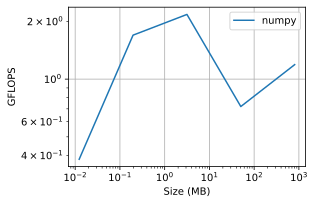

In [6]:
np_bcast_add = lambda s1, s2: timeit.Timer(setup='import numpy as np\n'
                                'import d2ltvm\n'
                                'a, b, c = d2ltvm.get_bcast_data(%s, %s)' % (s1, s2),
                                stmt='np.add(a, b, out=c)')
exe_times = [d2ltvm.bench_workload(np_bcast_add((n, 1), (n, n)).timeit) for n in sizes]
np_gflops = sizes * sizes / 1e9 / np.array(exe_times)
logging.info(f"NumPy GFLOPS: {np_gflops.tolist()}") # 转换为列表以便日志清晰输出
# data size in MB
x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
plot_gflops(x_axis_sizes, [np_gflops], ['numpy'], xlabel='Size (MB)')

%% [markdown]<br>
Note that the x axis is denoted as the total data size consumed. The performance drops when the data size is larger than the L2 cache of a single core (1024 KB or 1 MB), which indirectly suggests that `numpy` may use single-thread to perform this operator.<br>
<br>
## Good Schedule<br>
<br>
The following code block defines a benchmarking method for broadcast add of a specific pattern in TVM. It follows the same format we discussed in :numref:`ch_vector_add_cpu`.<br>


%%<br>
FIX: 将 target 更改为更通用的 'llvm'，以避免 "Illegal instruction" 错误<br>
原文: target = 'llvm -mcpu=skylake-avx512'

In [7]:
target = 'llvm' 
logging.info(f"TVM 编译目标 (target): {target}")

INFO: TVM 编译目标 (target): llvm


Save to the d2ltvm package.

In [8]:
def bench_bcast_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        n = int(n)
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_bcast_data((n, 1), (n, n), lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes * sizes / 1e9 / np.array(times)

%% [markdown]<br>
The good schedule (i.e. what works) follows the similar scheme defined in :numref:`ch_vector_add_cpu`.<br>


%%

In [9]:
def default(n):
    A, B, C = d2ltvm.broadcast_add((n, 1), (n, n))
    s = te.create_schedule(C.op)
    logging.debug(f"Default schedule created for n={n}")
    return s, (A, B, C)

In [10]:
def good_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    s[C].vectorize(y)
    logging.debug(f"Good schedule applied for n={n}: parallel(x), vectorize(y)")
    return s, (A, B, C)

In [11]:
s, args = good_schedule(64)
logging.info("--- 优良调度 (Good Schedule) 的低级 IR (n=64) ---")
print(tvm.lower(s, args, simple_mode=True)) # 打印 IR 内容

INFO: --- 优良调度 (Good Schedule) 的低级 IR (n=64) ---


# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 1), "float32"), B: T.Buffer((64, 64), "float32"), T_add: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0 in T.parallel(64):
            cse_var_1: T.int32 = ax0 * 64
            T_add_1 = T.Buffer((4096,), data=T_add.data)
            A_1 = T.Buffer((64,), data=A.data)
            B_1 = T.Buffer((4096,), data=B.data)
            T_add_1[cse_var_1:cse_var_1 + 64] = T.Broadcast(A_1[ax0], 64) + B_1[cse_var_1:cse_var_1 + 64]


%% [markdown]<br>
Now the C-like pseudo code should be familiar to you. One notable difference from :numref:ch_vector_add_cpu is that we broadcast `A[x]` to a vectorized register (i.e. `x64(A[x]`) for vectorized add.<br>
<br>
Let's benchmark the good schedule.<br>


%%

INFO: 基准测试 TVM 优良调度 (Good Schedule) ...
INFO: 优良调度 GFLOPS: [0.12351624979519768, 1.6352011101298114, 9.154608735934191, 1.310813153204567, 1.422396140143057]


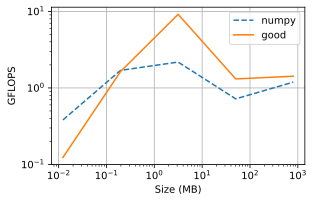

In [12]:
logging.info("基准测试 TVM 优良调度 (Good Schedule) ...")
good_gflops = bench_bcast_add_tvm(good_schedule, sizes, target)
logging.info(f"优良调度 GFLOPS: {good_gflops.tolist()}")
plot_gflops(x_axis_sizes, [np_gflops, good_gflops], ['numpy', 'good'], xlabel='Size (MB)')

%% [markdown]<br>
Like the case in :numref:`ch_vector_add_cpu`, the performance is better and drops at a larger data size as multi-core comes into play, leading to a larger amount L2 cache in total.<br>
<br>
## Bad Schedule<br>
<br>
Now let's see how a bad schedule (i.e. what doesn't work) looks like. Note that our data are all stored in row-major and our schedules always make sure that the innermost loop manipulates the data in consecutive space.<br>
<br>
However, if we think from the perspective vectorization, we may find that broadcasting `A[x]` to a vectorized register brings overhead. A better way is to have multiple values of `A` to add with multiple values of `B` in a vectorized instruction, which is illustrated in :numref:`fig_bcast_add_vectorize`.<br>
<br>
![Different vectorization strategies of broadcast add.](../img/bcast_add_vectorize.svg)<br>
:label:`fig_bcast_add_vectorize`<br>
<br>
In order to make vectorization along the column, we need to reorder to data access pattern as follows.<br>


%%

In [13]:
def bad_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].reorder(y, x)
    s[C].parallel(y)
    s[C].vectorize(x)
    logging.debug(f"不良调度 applied for n={n}: reorder(y,x), parallel(y), vectorize(x)")
    return s, (A, B, C)

In [14]:
s, args = bad_schedule(64)
logging.info("--- 不良调度 (Bad Schedule) 的低级 IR (n=64) ---")
print(tvm.lower(s, args, simple_mode=True)) # 打印 IR 内容

INFO: --- 不良调度 (Bad Schedule) 的低级 IR (n=64) ---


# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 1), "float32"), B: T.Buffer((64, 64), "float32"), T_add: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax1 in T.parallel(64):
            T_add_1 = T.Buffer((4096,), data=T_add.data)
            A_1 = T.Buffer((64,), data=A.data)
            B_1 = T.Buffer((4096,), data=B.data)
            T_add_1[ax1:ax1 + 4096:64] = A_1[0:64] + B_1[ax1:ax1 + 4096:64]


%% [markdown]<br>
Now we eliminate the broadcast of `A[x]` in vectorization. Let's run the benchmark and plot the chart for this schedule.<br>


%%

In [15]:
sizes_for_bad_schedule = 2**np.arange(5, 11, 2) # 不良调度只测试部分大小以节省时间
logging.info(f"基准测试 TVM 不良调度 (Bad Schedule)，数据大小范围 n={sizes_for_bad_schedule.tolist()}")

INFO: 基准测试 TVM 不良调度 (Bad Schedule)，数据大小范围 n=[32, 128, 512]


In [16]:
bad_gflops = bench_bcast_add_tvm(bad_schedule, sizes_for_bad_schedule, target)
logging.info(f"不良调度 GFLOPS: {bad_gflops.tolist()}")

INFO: 不良调度 GFLOPS: [0.0912117110365765, 0.5105831962477316, 0.594548655495792]


为了绘图，将不良调度结果填充 NaN 以匹配优良调度的长度

In [17]:
diff = len(good_gflops)-len(bad_gflops)
bad_gflops_padded = np.append(bad_gflops, [np.nan] * diff) # 使用明确的变量名

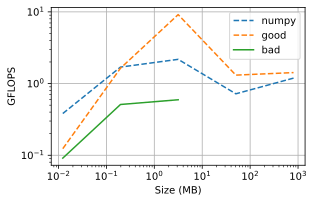

In [18]:
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops_padded],
     ['numpy', 'good', 'bad'],  xlabel='Size (MB)')

%% [markdown]<br>
Note that in order to make it finish in a short period of time, we reduce the number of tested sizes for this schedule.<br>
<br>
We can see that the performance of the vectorization-favorable schedule is pretty bad. The reason is that we access `B` in a stride to get the data in the same column, which is much slower than accessing data in a consecutive space. And the thread-level parallelism would make it even worse as different threads compete in getting the data in the same cache line.<br>
<br>
The result shows that a good schedule needs to consider multiple performance-related factors together. A scheduling scheme that favors one aspect may lead to bad overall performance as it harms other aspects.<br>
<br>
## Summary<br>
<br>
- Like vector add, broadcast add is a memory-bound operator.<br>
- A good schedule needs to consider multiple performance-related factors together.<br>
<br>
## Exercise<br>
<br>
- Try to schedule other broadcast add patterns and observe the difference.